In [1]:
import evaluate
import random

import torch
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader 
from tqdm import tqdm

# Logging
import wandb 

# Visualization Tools
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Our code
from dataloader import *
from trainer import POCMLTrainer
from model import POCML, sim
from visualizer import * 
from utils import *


# Environment & Data Configuration

In [2]:
torch.autograd.set_detect_anomaly(True)

n_nodes = 9
#batch_size = 16        # Note: in og CML trajectory length == batch_size; in POCML this should be decoupled
n_obs = 9
trajectory_length = 16  # numer of node visits in a trajectory
num_desired_trajectories= 30

env = GraphEnv( n_items=n_nodes,                     # number of possible observations
                env='grid', 
                batch_size=trajectory_length, 
                num_desired_trajectories=num_desired_trajectories, 
                device=None, 
                unique=True,                         # each state is assigned a unique observation if true
                args = {"rows": 3, "cols": 3}
            )

train_dataset = env.gen_dataset()
test_dataset = env.gen_dataset()

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Set config & hyperparameter pools for wandb

In [3]:
# Convention: for each hyperparameter key, set the value to a list if you want to try multiple values
param_pool = {  
    # data-related config; can't be automated for now
    "n_obs" : env.n_items,
    "n_states" : env.size,
    "n_actions" : env.n_actions,
    "trajectory_length" : trajectory_length,  # numer of node visits in a trajectory
    "num_desired_trajectories" : num_desired_trajectories,
    # Experiments
    "seed": [68, 70],
    # model 
    "state_dim" : [20],
    "random_feature_dim" : 1000,
    "alpha" : [2],
    "memory_bypass" : True,
    # trainer
    "lr_Q" : 0.1, 
    "lr_V" : [0.1], 
    "lr_all" : 0.005,
    "normalize" : False,
    "reset_every" : 1,#[1, 5, 10],
    "update_state_given_obs": [True],
    # training / optimizer 
    "epochs" : 400,
}

debug = False
log = True

In [4]:
def generate_run_name(params):
    # TODO cutomize run name
    name = f"grid3x3_sdim_{params['state_dim']}_rfdim_{params['random_feature_dim']}_a_{params['alpha']}_bypass_{params['memory_bypass']}_usgo_{params['update_state_given_obs']}"
    return name

In [5]:
def run_trial(params, train_dataloader, test_dataloader, debug=False, log=False):

    run_name = generate_run_name(params)

    if log: 
        wandb.init(
            # Set the project where this run will be logged
            project="POCML",
            # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
            name=run_name,
            # Track hyperparameters and run metadata
            config = params,
            # config={
            #     "learning_rate": 0.02,
            #     "architecture": "CNN",
            #     "dataset": "CIFAR-100",
            #     "epochs": 10,
            # },
            )

    # Set random seed
    seed = params["seed"]
    set_random_seed(seed)

    # Filter parameters to match the model & trainer's __init__ signature
    trainer_params = filter_param(params, POCMLTrainer)
    model_params = filter_param(params, POCML)

    # Instantiate the model & trainer using the filtered dictionary
    model = POCML(**model_params)
    trainer = POCMLTrainer(model = model, train_loader = train_dataloader, log = log, debug =debug, **trainer_params)
    # train the model and record its loss
    # loss_record = np.array(trainer.train(params["epochs"])).reshape(params["epochs"],-1)
    loss_record, model = trainer.train(params["epochs"])
    
    ## Analytics
    # get state & action kernel similarities
    phi_Q = model.get_state_kernel()
    phi_V = model.get_action_kernel()
    k_sim_Q = sim(phi_Q, phi_Q)
    k_sim_V = sim(phi_V, phi_V)

    ## Evaluations
    train_acc, train_confidences = evaluate.accuracy(model, train_dataloader)
    test_acc, test_confidences = evaluate.accuracy(model, test_dataloader)
    sa_acc, sa_confidences, sa_distance_ratios = evaluate.state_transition_consistency(model, env)

    if debug: 
        print("State kernel similarities:\n", k_sim_Q)
        print("Action kernel similarities:\n", k_sim_V)

        print("Train obs accuracy/confidence:", train_acc, np.mean(train_confidences))
        print("Test obs accuracy/confidence:", test_acc, np.mean(test_confidences))
        print("State-action accuracy/confidence/distance ratio:", sa_acc, np.mean(sa_confidences), np.mean(sa_distance_ratios))

    ## Visualization 
    visualize(model.get_state_differences().numpy(), legend = "State", title = "MDS State Differences", log = log)
    visualize(model.get_action_differences().numpy(), legend = "Action", title = "MDS Action Differences", log = log)
    visualize_loss(loss_record, num_desired_trajectories, trajectory_length, per_epoch=False)
    visualize_loss(loss_record, num_desired_trajectories, trajectory_length, per_epoch=True)

    # # Log train and validation metrics to wandb
    # TODO  
    # metrics = {}
    # val_metrics = {"val/val_loss": val_loss,
    #                 "val/val_accuracy": accuracy}
    # wandb.log({**metrics, **val_metrics})

    # Log the results
    wandb.summary['train_acc'] = train_acc
    wandb.summary['train_conf'] = np.mean(train_confidences)
    wandb.summary['test_accuracy'] = test_acc
    wandb.summary['test_conf'] = np.mean(test_confidences)
    wandb.summary['sa_accuracy'] = sa_acc
    wandb.summary['sa_conf'] = np.mean(sa_confidences)
    wandb.summary['sa_dist_ratio'] = np.mean(sa_distance_ratios)

    wandb.finish()

    # TODO log models
    # # beta_obs, beta_state, clean up rate
    # torch.save(model.state_dict(), "model/model_12_12_1.ckpt")

    return trainer

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chyeung (evanjeong). Use `wandb login --relogin` to force relogin


Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

/Users/calvin/miniforge3/envs/pytorch/lib/python3.12/site-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


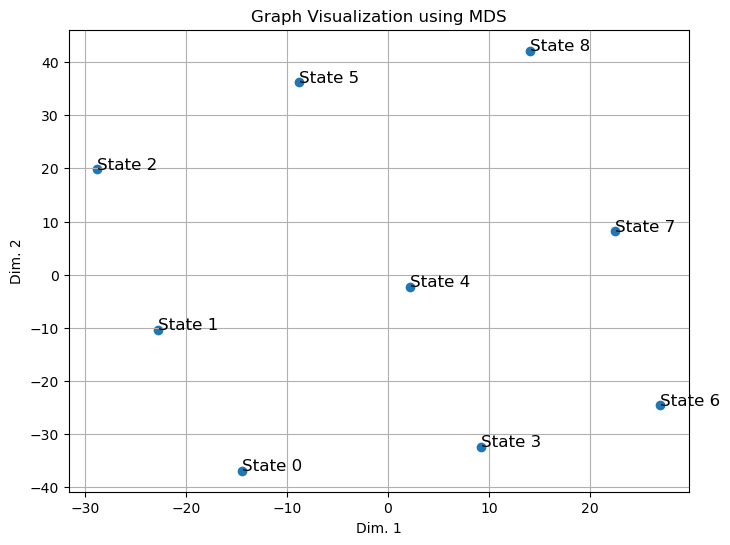

/Users/calvin/miniforge3/envs/pytorch/lib/python3.12/site-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


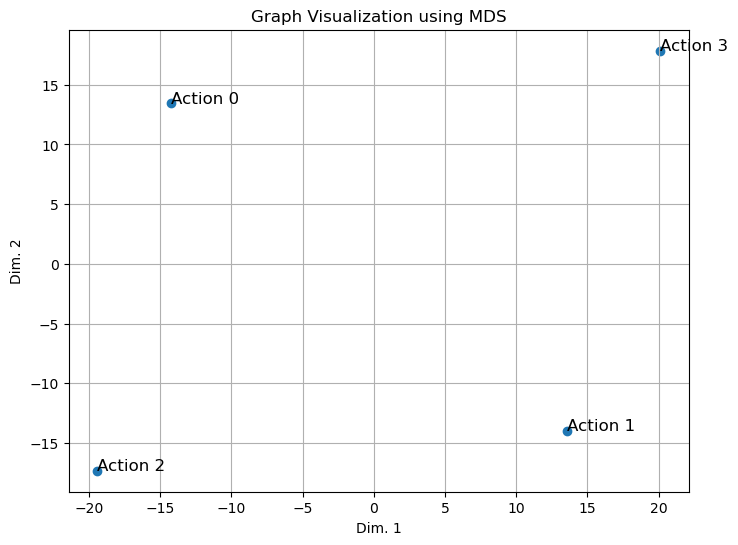

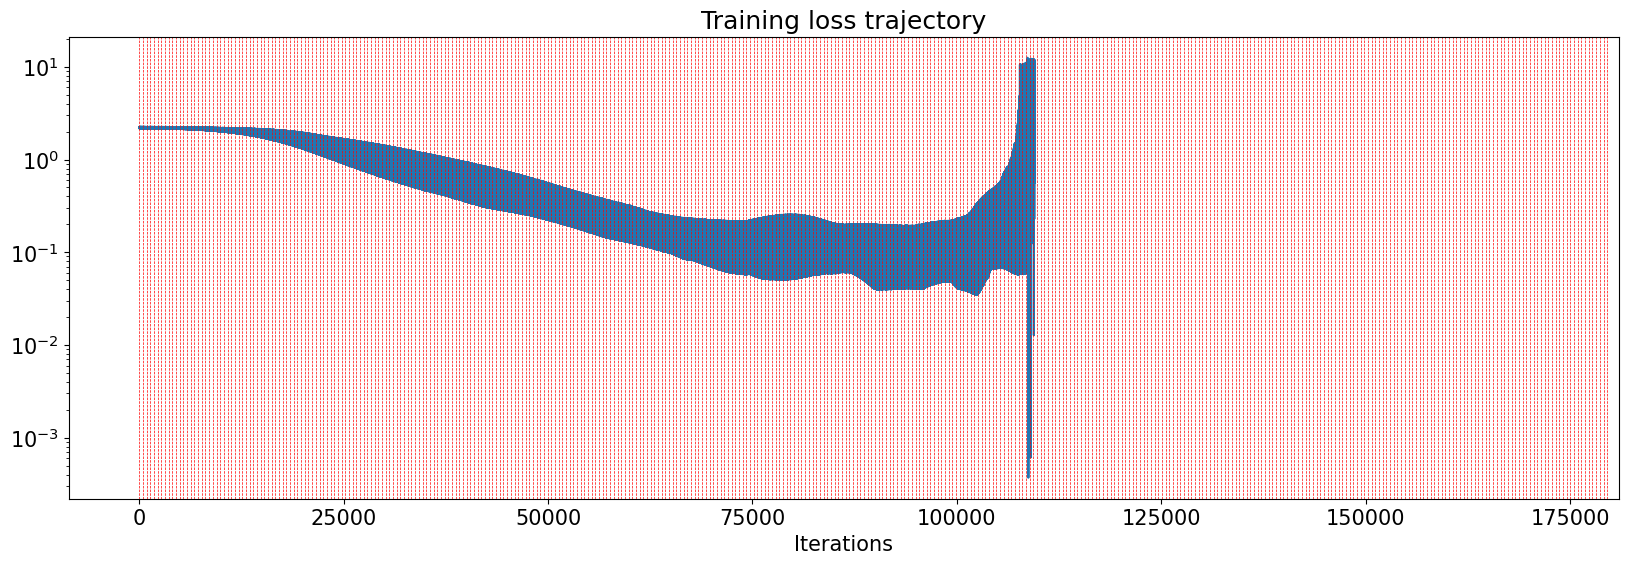

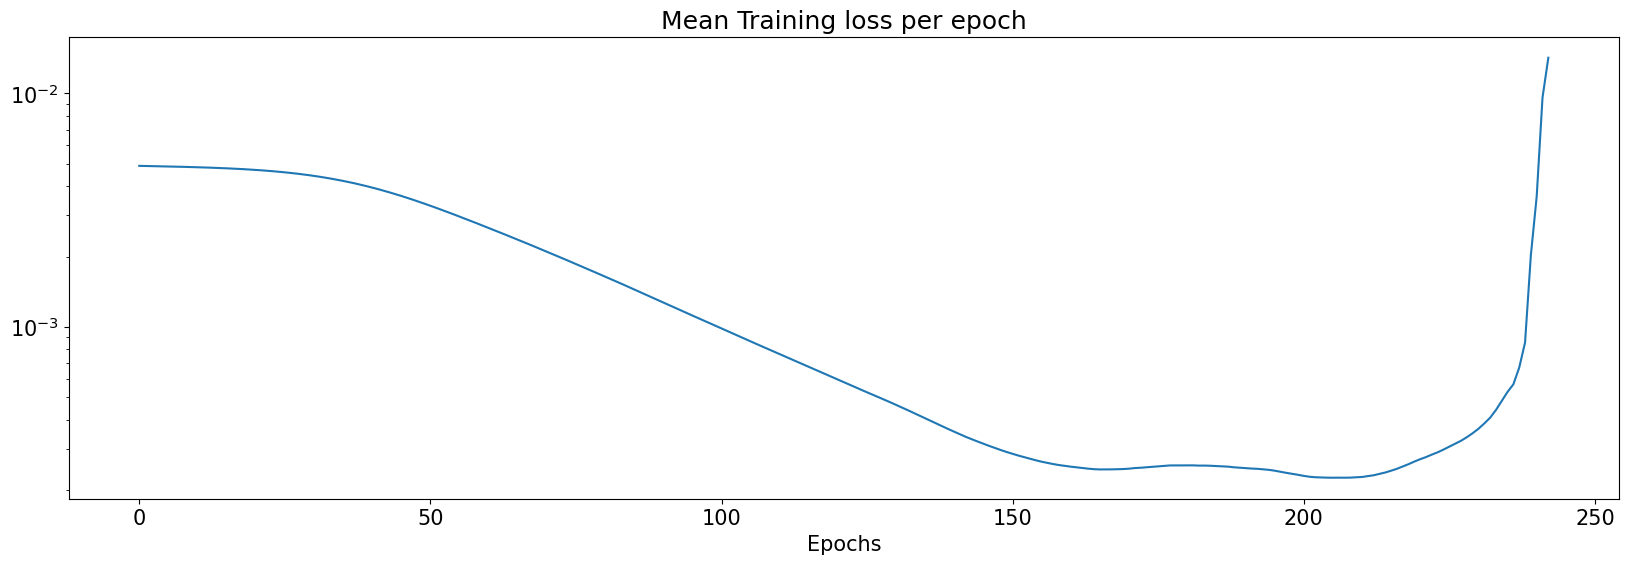

train/epoch_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/loss,████▆▄▅▃▃▄▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁
train/mloss_p_epoch,███▇▆▆▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/mloss_p_traj,▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
train/step_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/traj_ct,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
sa_accuracy,1.0
sa_conf,0.89781
sa_dist_ratio,0.27697
test_accuracy,1.0
test_conf,0.89405


Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

/Users/calvin/miniforge3/envs/pytorch/lib/python3.12/site-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


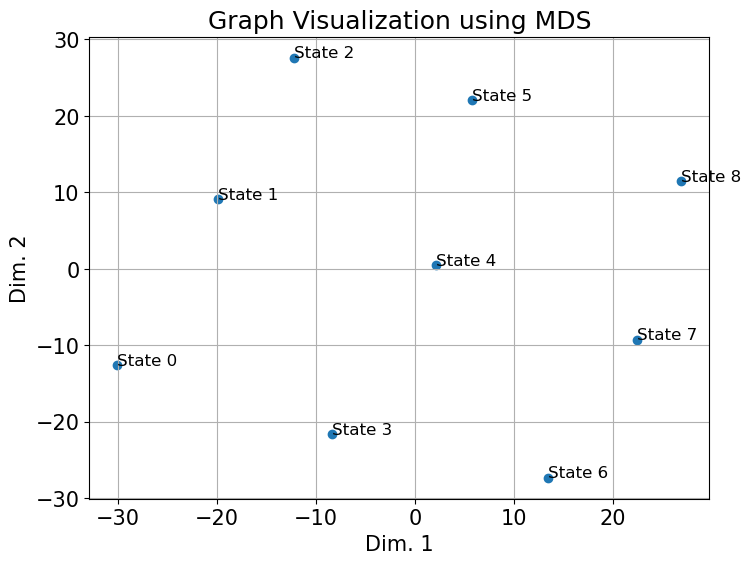

/Users/calvin/miniforge3/envs/pytorch/lib/python3.12/site-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


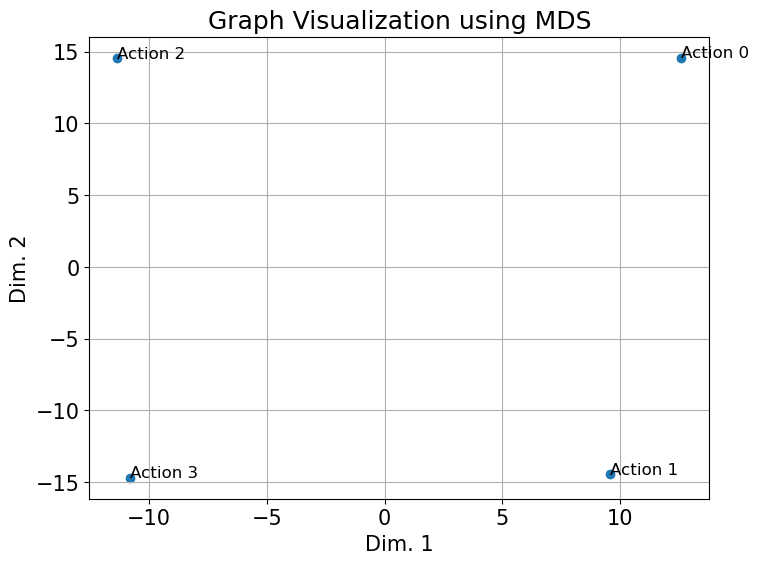

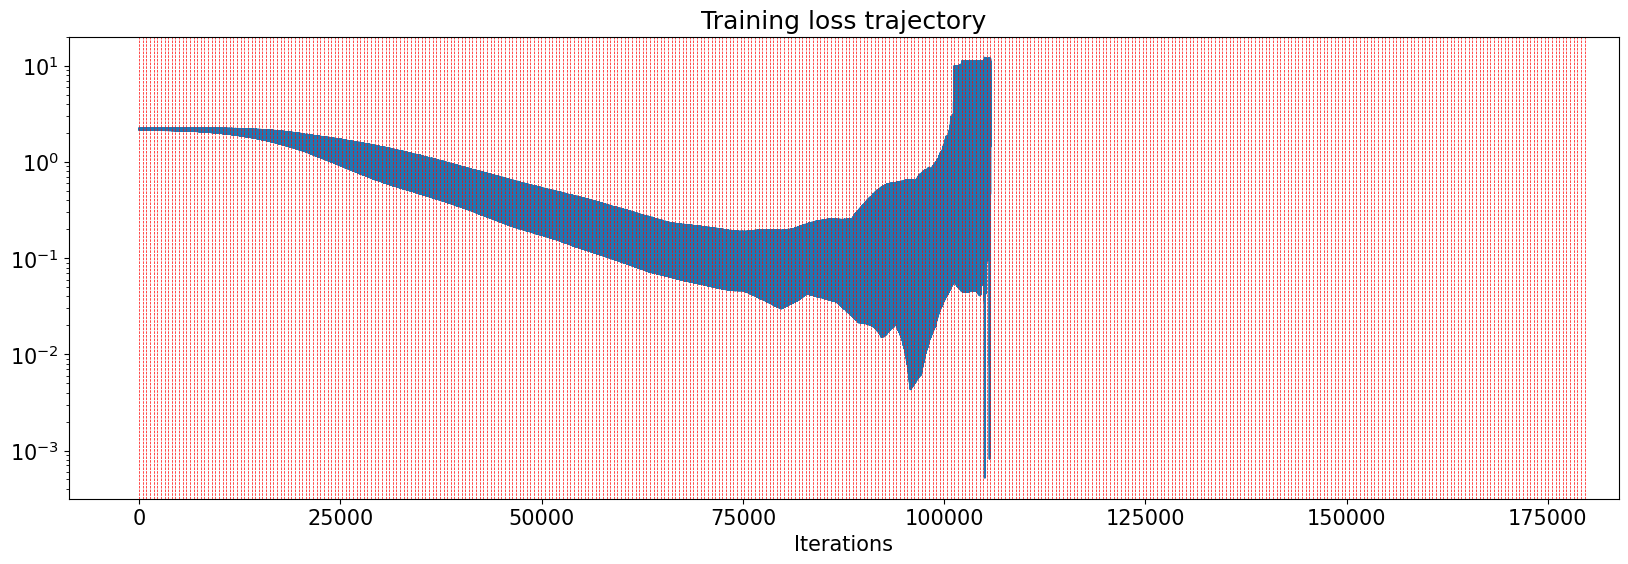

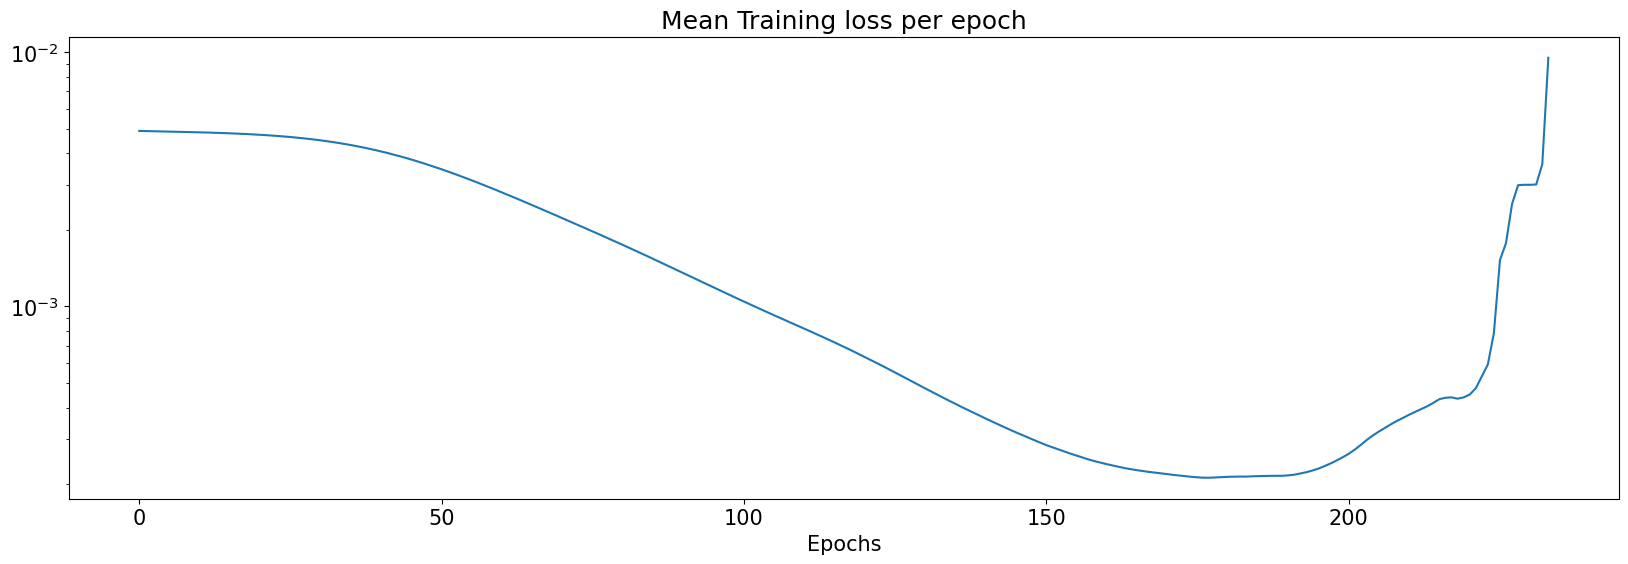

train/epoch_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/loss,▄▄▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
train/mloss_p_epoch,███▇▇▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▂
train/mloss_p_traj,▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁█
train/step_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/traj_ct,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
sa_accuracy,1.0
sa_conf,0.90272
sa_dist_ratio,0.28095
test_accuracy,1.0
test_conf,0.89971


In [6]:
# Use the loader to generate combinations one at a time
param_loader = generate_combinations_loader(param_pool)

for params in param_loader:
    model = run_trial(params, train_dataloader, test_dataloader, debug=debug, log=log)
